In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

In [2]:
def RunHom_DoubleDiffusion(D_e,D_EC,D_cross,t_0plus,trans_i):
    # constant definition
    i_app = 4.8;   F = 9.6E4;
    c_init = 1000; c_EC_init= 4000; c_tot_init = 6000; 

    model = pybamm.BaseModel()
    c  = pybamm.Variable("Li+ Concentration", domain="negative electrode")
    co = pybamm.Variable("EC Concentration", domain="negative electrode")
    N    = - D_e*pybamm.grad(c) - D_cross*(c_init/c_tot_init)*pybamm.grad(co) + t_0plus*i_app/F  # define the Li+ flux
    N_EC = - D_cross*(c_EC_init/c_tot_init)*pybamm.grad(c) - D_EC*pybamm.grad(co) - trans_i*i_app/F  # define the EC flux
    dcdt  = -pybamm.div(N)     # define the rhs equation for Li+
    dcodt = -pybamm.div(N_EC)  # define the rhs equation for EC
    model.rhs = {c: dcdt,co:dcodt}  # add the equation to rhs dictionary
    # initial conditions
    model.initial_conditions = {c: pybamm.Scalar(c_init),co: pybamm.Scalar(c_EC_init)}
    # boundary conditions

    # calculate for boundary conditions:
    a1 = D_e;                               b1 = D_cross * (c_init/c_tot_init);   

    c1_left = -(1-t_0plus)*i_app/F; 
    c1_right = -(1-t_0plus)*i_app/F;

    a2 = D_cross * (c_EC_init/c_tot_init);  b2 = D_EC;                            c2 = -trans_i*i_app/F;

    y_temp_left = (c2 - a2/a1*c1_left) / (b2 - a2/a1*b1);   x_temp_left = (c1_left - b1*y_temp_left) / a1
    y_temp_right = (c2 - a2/a1*c1_right) / (b2 - a2/a1*b1);   x_temp_right = (c1_right - b1*y_temp_right) / a1


    model.boundary_conditions = {
        c: {"left": (x_temp_left, "Neumann"),"right": (x_temp_right, "Neumann")},  
        co: {"left": (y_temp_left, "Neumann"),"right": (y_temp_right, "Neumann")} }
    model.variables = {"Li+ Concentration": c, "Li+ Flux": N,"EC Concentration": co, "EC Flux": N_EC}
    # define geometry
    x = pybamm.SpatialVariable(
        "x", domain=["negative electrode"], coord_sys="cartesian"
    )
    geometry = {"negative electrode": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(8e-3)}}}
    #model.length_scales = {"negative electrode": 1e1,}
    #model.timescale = pybamm.Scalar(8e-3 ** 2 /  D_e) 
    # mesh and discretise
    submesh_types = {"negative electrode": pybamm.MeshGenerator(pybamm.Uniform1DSubMesh)}
    var_pts = {x: 40}
    mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
    spatial_methods = {"negative electrode": pybamm.FiniteVolume()}
    disc = pybamm.Discretisation(mesh, spatial_methods)
    disc.process_model(model);

    # solve
    solver = pybamm.ScipySolver()
    t = np.linspace(0, 100, 100)
    solution = solver.solve(model, t)

    # post-process, so that the solution can be called at any time t or space r
    # (using interpolation)
    c = solution["Li+ Concentration"];  co = solution["EC Concentration"];

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    x= np.linspace(0, 8e-3, 100)
    ax1.plot(x, co(t=0.01, x=x))
    ax1.plot(x, co(t=10, x=x))
    ax1.plot(x, co(t=60, x=x))
    ax1.plot(x, co(t=80, x=x))
    ax1.plot(x, co(t=100, x=x))
    ax1.set_xlabel("x")
    ax1.set_ylabel("EC concentration [mol/m3]")
    ax1.set_title(f"D_EC = {D_EC}, D_cross = {D_cross}")


    ax2.plot(x, c(t=0.01, x=x))
    ax2.plot(x, c(t=10, x=x))
    ax2.plot(x, c(t=60, x=x))
    ax2.plot(x, c(t=80, x=x))
    ax2.plot(x, c(t=100, x=x))
    ax2.set_xlabel("x")
    ax2.set_ylabel("Li+ concentration [mol/m3]")
    ax2.set_title(f"D_EC = {D_EC}, D_cross = {D_cross}")
    plt.tight_layout()
    plt.show()

    return 

In [24]:
# constant definition    D_e,D_EC,D_cross,t_0plus,trans_i
D_e = 3e-10;  D_EC = 5e-10; D_cross = 1.5e-9;   t_0plus = 0.3; trans_i = -1.4;  

2022-09-06 15:54:31,113 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].
2022-09-06 15:54:31,121 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].


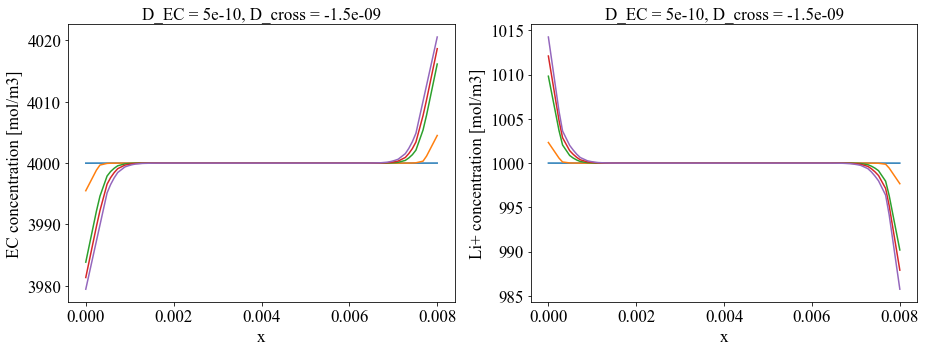

2022-09-06 15:54:31,431 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].
2022-09-06 15:54:31,438 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].


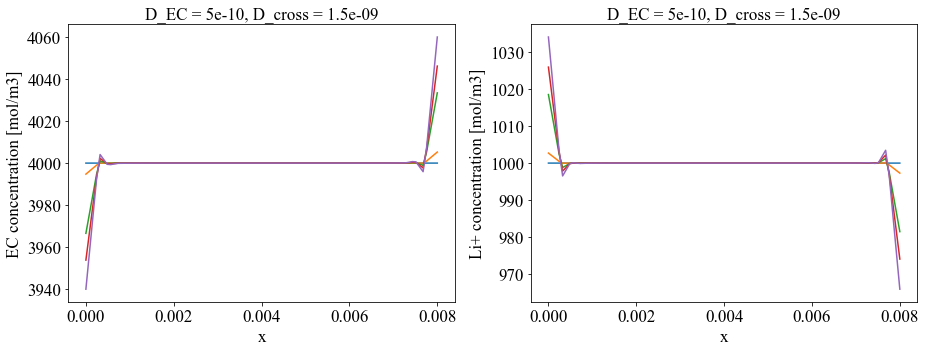

In [26]:
RunHom_DoubleDiffusion(D_e,D_EC,-D_cross,t_0plus,-1.4)
RunHom_DoubleDiffusion(D_e,D_EC,D_cross,t_0plus,-1.4)

2022-09-06 15:05:11,555 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].
2022-09-06 15:05:11,565 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].


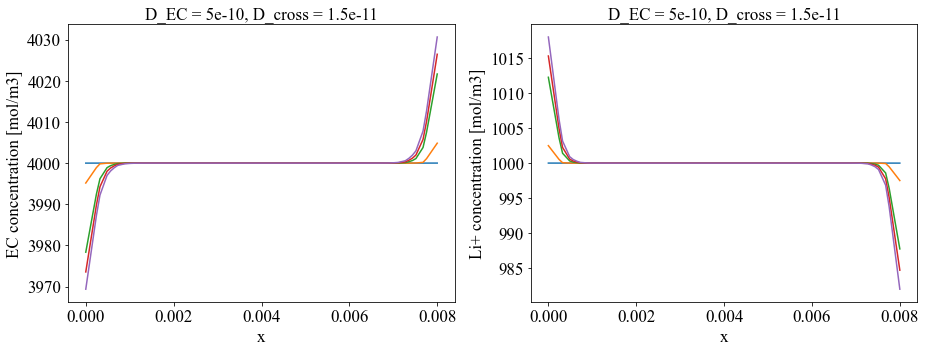

2022-09-06 15:05:11,920 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].
2022-09-06 15:05:11,929 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].


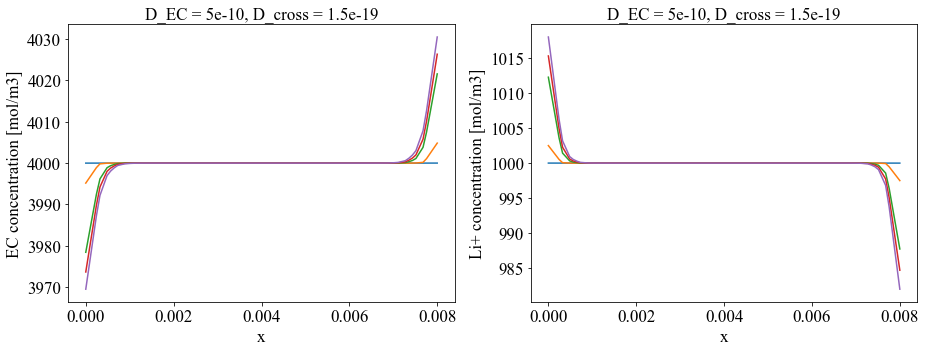

In [22]:
RunHom_DoubleDiffusion(D_e,D_EC,D_cross/1e2,t_0plus,-1.4)
RunHom_DoubleDiffusion(D_e,D_EC,D_cross/1e10,t_0plus,-1.4)

2022-09-06 15:04:17,067 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].
2022-09-06 15:04:17,078 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].


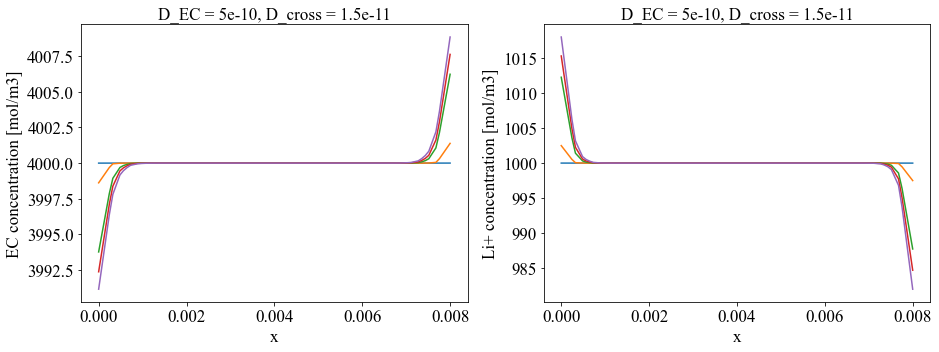

In [19]:
RunHom_DoubleDiffusion(D_e,D_EC,D_cross/1e2,t_0plus,-0.4)

2022-09-06 15:04:39,888 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].
2022-09-06 15:04:39,895 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].


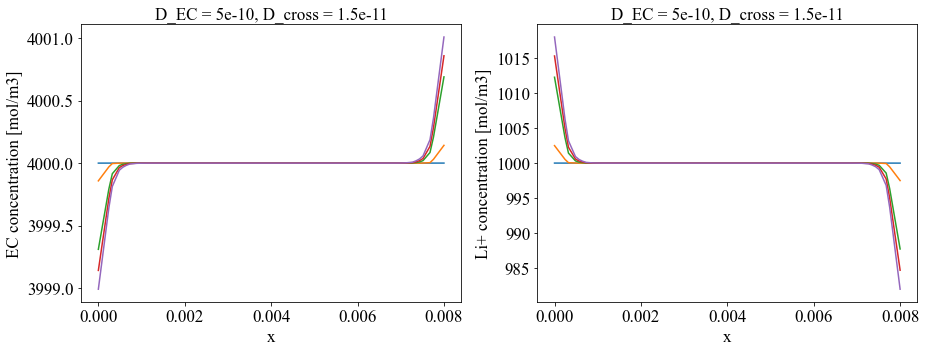

In [20]:
RunHom_DoubleDiffusion(D_e,D_EC,D_cross/1e2,t_0plus,-0.04)

2022-09-06 13:15:24,997 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].
2022-09-06 13:15:25,007 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].


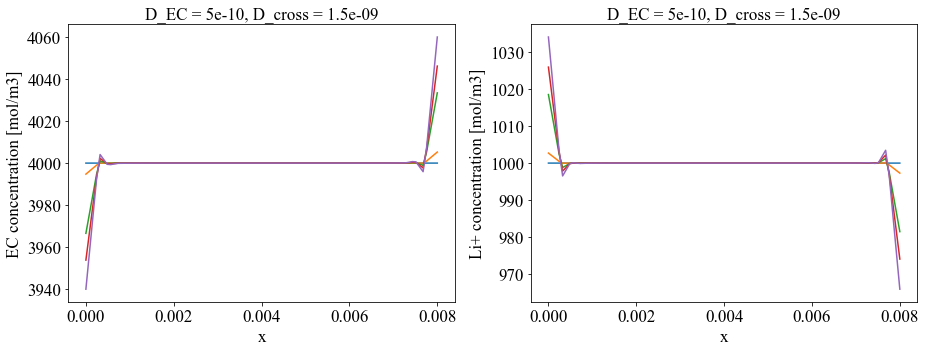

In [11]:
RunHom_DoubleDiffusion(D_e,D_EC,-D_cross,t_0plus,trans_i)

2022-09-06 13:15:25,342 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].
2022-09-06 13:15:25,351 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].


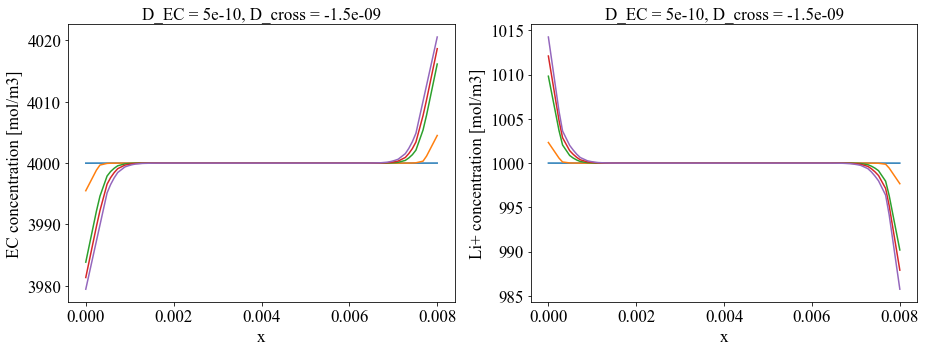

In [12]:
RunHom_DoubleDiffusion(D_e,D_EC,D_cross,t_0plus,trans_i)